# Introduction

This notebook will describe a SIMPLE  **audio classification** problem using a **Fully-Connected** neural network.

**Food identification** technology potentially benefits both food and media industries and improves human-computer interaction.

This food classification dataset is based on 246 YouTube videos of 20 food types.

# Common Audio Classification Process:

The standard way to classify audio is based on **Spectogram & CNN Models**. 

[Spectogram](https://en.wikipedia.org/wiki/Spectrogram) is a **Pre-processing step**, where every audio signal convert from a time domain to a frequency/time domain using [FFT Methods](https://en.wikipedia.org/wiki/Fast_Fourier_transform).

* In practice, the time/frequency domain is a two-dimension matrix: the y-axis is the frequency, and the x-axis is the time, and it's a kind of "picture."
* Because it's a picture, it can be trained & classified using **CNN Models**.


**Note:** The x-axis length is changing via the time duration of the sample - the spectrogram picture WIDTH has no constraints and is needed to resize.


**Summary:** The typical way to classify audio is by transforming it into a picture (spectrogram) in the pre-processing step and training it using a CNN model.

# My Architecture Considerations:


* The system will handle **any signal length** as an input.
* The system **won't** need any padding in the pre-processing.

# Features Engineering:

**Background:** in simple words (and not academic) [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) is a kind of "smart" spectrogram, analyzing audio signals regards to the human ears biology & capabilities.   

I calculated the **MEAN** of the MFCC coefficients to be the **features space** to accomplish the architecture.

[Librosa](https://librosa.org/doc/latest/index.htmlhttps://librosa.org/doc/latest/index.html) is a package music and audio analysis, and I used it to calculate the mfcc. 

**Advantages:**
* The system won't be affected by time duration.
* The network can be a simple, fully connected network
* Low-time training.
* Minimum parameters\wehigths.

* Minimum parameters\wehigths.

# #00 - Hyper Parameters

In [1]:
import librosa
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import os
from os.path import join

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU 
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


# ========================================================
# Hyper parameters
# ========================================================

# Hyper Parameters - Preprocessing (for mfcc coefficients)
hop_length = 512
n_fft = 2048
n_mfcc = 64

# Hyper Parameters - for FC neural network model
learning_rate=1e-3
batch_size = 32
n_epoch = 200
drop_rate = 0.3
drop_seed = 1
val_split = 0.2
optimizer = Adam(learning_rate=learning_rate)
func_loss = CategoricalCrossentropy(from_logits=True)

# Paths
data_path = r'../input/eating-sound-collection/clips_rd'

extracted_features_path = "_".join([r'hop_length', str(hop_length),
                                    'n_fft', str(n_fft),
                                    'n_mfcc', str(n_mfcc)])

# #01 - Loading the Dataset

To analyze the dataset, we'll create a data frame that include:
* Files paths, 
* Class of each file
* Duration (in seconds) of each audio signal

In [2]:
# ========================================================
# Define the dataset
# l = List
# df = Dataframe
# ========================================================

classes = os.listdir(data_path)

# Define files list
l_files = [[join(data_path, cls, file), cls]
           for cls in classes
           for file in os.listdir(join(data_path, cls))]

# Add Columns names
df_files = pd.DataFrame(l_files, columns=('path', 'label'))

# Calculate duration
for i, row in tqdm(df_files.iterrows()):
    df_files.at[i, 'duration'] = librosa.get_duration(filename=row['path'])

11140it [01:25, 130.80it/s]


# #02 - Dataset Overview

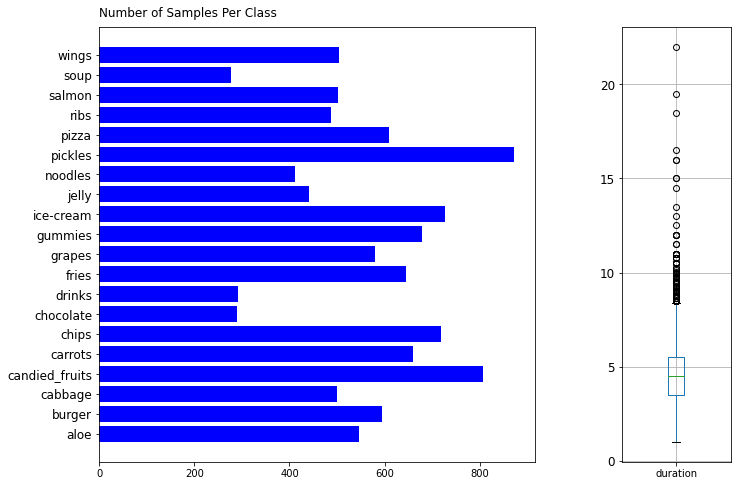

In [3]:
def dataset_overview(df):
    """Dataset Total Instances"""
    class_dist = df.groupby(['label'])['duration'].count()

    plt.figure(1, figsize=[16, 8])
    gs = GridSpec(1, 14, wspace=0.5, hspace=0.25)

    plt.subplot(gs[:, :7])
    plt.barh(class_dist.index, class_dist, color='b')
    plt.yticks(rotation=0, fontsize=12)
    plt.title('Number of Samples Per Class', pad=10, loc='left')

    plt.subplot(gs[:, 8:10])
    df_files.boxplot(rot=0)
    plt.yticks(rotation=0, fontsize=12)
    plt.suptitle('')
    plt.show()


dataset_overview(df_files)


#  Dataset Insights:

* The classes aren't balanced.
* Most of the signals are 5-6 seconds long
* There are few signals longer than 10 seconds

# #03 - Pre-Processing: Extracting Scaled MFCC Features

The pre-processing is a long time process (around 40 minutes).

To save time, I uploaded the mfcc NumPy files as a dataset - you can load them directly in section 04

In [4]:
# ========================================================
# f = features
# l = List
# ========================================================

extracted_features_path = "_".join(['hop_length', str(hop_length),
                                    'n_fft', str(n_fft),
                                    'n_mfcc', str(n_mfcc)])

def extract_features(dataset):
    l_features_scale = []
    l_labels = np.array(pd.get_dummies(dataset['label']))

    '''Create mfcc matrix'''

    for index, file in tqdm(dataset.iterrows()):

        # Load audio files
        signal, sample_rate = librosa.load(file['path'])

        # Extract MFCC Coefficients
        f_mfcc = librosa.feature.mfcc(signal,
                                      sr=sample_rate,
                                      n_mfcc=n_mfcc,
                                      hop_length=hop_length)

        # Scale MFCC
        f_mfcc_scaled = np.mean(f_mfcc.T, axis=0)
        l_features_scale.append(f_mfcc_scaled)
            
    np.save('./features_mfcc_scaled_' + extracted_features_path, l_features_scale)
    np.save('./labels_mfcc_scaled_' + extracted_features_path, l_labels)

    return np.array(l_features_scale), np.array(l_labels)


features_1D, labels = extract_features(df_files)


11140it [50:05,  3.71it/s]


# #04 - Train/Test Split 

Loading the pre-saved MFCC matrix and labels vector, and split them to train/test datasets

In [5]:
scaled_features = np.load( '../input/eating-sound-collection-extracted-mfcc-features/features_mfcc_scaled_' + extracted_features_path + '.npy')

labels = np.load( '../input/eating-sound-collection-extracted-mfcc-features/labels_mfcc_scaled_' + extracted_features_path + '.npy')

x_train, x_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=10)

# #05 - Build & Train a Simple FC Model:

In [6]:
def build_fc_audio_model():
    i = Input(shape=(n_mfcc,), name="mfcc")
    x = Dense(512, name="FC_1")(i)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(rate=drop_rate, seed=drop_seed)(x)

    x = Dense(256, name="FC_2")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(rate=drop_rate, seed=drop_seed)(x)

    x = Dense(len(classes), name="FC_3")(x)

    model = Model(inputs=i, outputs=x, name='Audio-Class-Model')
    model.summary()

    return model


'''building the model:'''
model_1D = build_fc_audio_model()

model_1D.compile(optimizer=optimizer,
                 loss=func_loss,
                 metrics='accuracy')

'''fitting the model:'''
history = model_1D.fit(x_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=n_epoch,
                       validation_split=val_split)


Model: "Audio-Class-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfcc (InputLayer)            [(None, 64)]              0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               33280     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
FC_2 (Dense)                 (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)         

# #06 - Analysing Loss & Accuracy

The best results were with the MFCC 64 coefficients-  the results are below.

**You can create your mfcc matrix using the function in section 03.**

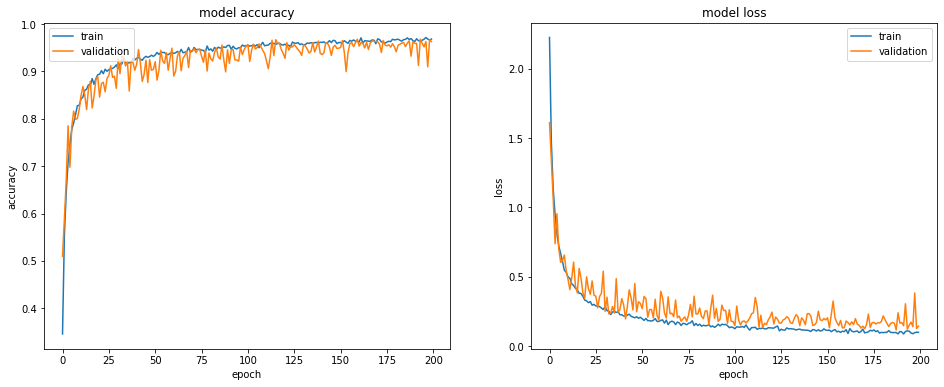

In [7]:
# summarize history for accuracy
plt.figure(1, figsize=[16, 6])
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# #07 - Testing

In [8]:
model_1D.evaluate(x_test, y_test, batch_size=batch_size)

70/70 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9574


[0.16076073050498962, 0.9573608636856079]

# #08 - Save the Model

In [9]:
model_1D.save(extracted_features_path +  '_FC_Model')